In [7]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.style.use('seaborn-whitegrid')
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")
import scipy as sp
from scipy.stats import beta
from scipy import stats

In [2]:
root_path = "results/"

In [3]:
import glob
import pandas as pd
dataset = "MovieLens100K"
results_files_list = glob.glob(f"{root_path}/{dataset}/*.csv")

In [4]:
all_dfs = []

for result_file in results_files_list:
    result_df = pd.read_csv(result_file)
    all_dfs.append(result_df)

# concat all of the dataframes
results_df = pd.concat(all_dfs)

In [ ]:
# print in latex format to put in the paper
# for eachline in results_df.itertuples(index=True):
  # print(f"{eachline.Model} & {eachline.Type} & {eachline.ndcg_ALL} & {eachline.CatCov_ALL} & {eachline.avg_JSH_all} & {eachline.avg_Hell_all} \\\\")

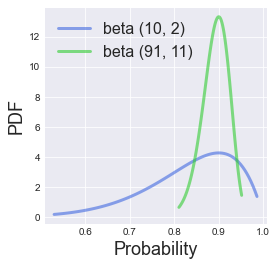

In [48]:
fig, ax = plt.subplots(1, 1, figsize =(4, 4))

a, b = 10, 2
mean, var, skew, kurt = beta.stats(a, b, moments='mvsk')

r1 = beta.rvs(a, b, size=10000000)

# x: prob

x = np.linspace(beta.ppf(0.01, a, b),
                beta.ppf(0.99, a, b), 100)
ax.plot(x, beta.pdf(x, a, b),
       'r-', lw=3, alpha=0.6, label='beta (10, 2)', color='royalblue')

a, b = 91, 11
mean, var, skew, kurt = beta.stats(a, b, moments='mvsk')

r2 = beta.rvs(a, b, size=10000000)

x = np.linspace(beta.ppf(0.01, a, b),
                beta.ppf(0.99, a, b), 100)
ax.plot(x, beta.pdf(x, a, b),
       'b-', lw=3, alpha=0.6, label='beta (91, 11)', color='limegreen')

ax.set_xlabel('Probability', fontsize=18)
ax.set_ylabel('PDF', fontsize=18)

plt.legend(fontsize=16)

plt.savefig('plots/dist.pdf', bbox_inches='tight')

### Barplot Test vs. Train

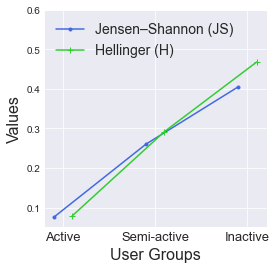

In [59]:
# set width of bar
barWidth = 0.20
fig = plt.subplots(figsize =(4, 4))
 
# set height of bar
JS = [0.07533822069457305, 0.2603085308559478, 0.4052769551083986]
Hell = [0.07875051012779152, 0.2919298883264158, 0.4679492188200486]
 
# Set position of bar on X axis
br1 = np.arange(len(JS))
br2 = [x + barWidth for x in br1]
 
# Make the plot
# plt.plot(br1, JS, width = barWidth, label ='Jensen–Shannon (JS)', color='royalblue')
# plt.plot(br2, Hell, width = barWidth, label ='Hellinger (H)', color='limegreen')
plt.plot(br1, JS, marker='.', label ='Jensen–Shannon (JS)', color='royalblue')
plt.plot(br2, Hell, marker='+', label ='Hellinger (H)', color='limegreen')
 
# Adding Xticks
plt.xlabel('User Groups', fontsize = 16)
plt.ylabel('Values', fontsize = 16)
plt.xticks([r + 0.1 for r in range(len(JS))], ['Active', 'Semi-active', 'Inactive'], fontsize = 13)
plt.ylim(ymin=0.05, ymax=0.6)
plt.legend(fontsize=14)
plt.savefig(f'plots/testvstrain.pdf', bbox_inches='tight')

### Heatmap for User Groups on CatCoverage

In [ ]:
heatmap_df = pd.DataFrame(columns=['Model', 'Type', 'UserGroup', 'CatCov', 'JS'])

for eachline in results_df.itertuples(index=True):
  if eachline.Model not in ['MostPop', 'ItemKNN-Cosine', 'UserKNN-BM25']:
    if eachline.Type in ['CL', 'CCL']:
      heatmap_df = heatmap_df.append({'Model': eachline.Model,'Type': eachline.Type, 'UserGroup': 'Active', 'CatCov': eachline.CatCov_POP, 'JS': eachline.avg_JSH_pop}, ignore_index=True)
      heatmap_df = heatmap_df.append({'Model': eachline.Model,'Type': eachline.Type, 'UserGroup': 'Semi-active', 'CatCov': eachline.CatCov_DIV, 'JS': eachline.avg_JSH_div}, ignore_index=True)
      heatmap_df = heatmap_df.append({'Model': eachline.Model,'Type': eachline.Type, 'UserGroup': 'Inactive', 'CatCov': eachline.CatCov_UNPOP, 'JS': eachline.avg_JSH_unpop}, ignore_index=True)

In [ ]:
# group heatmap dataframe by model
group_heatmap_df = heatmap_df.groupby('UserGroup')

In [ ]:
# generating heatmap for original and fair on UGF of Precision
df_Pop = group_heatmap_df.get_group('Active').pivot("Model", "Type", "CatCov")
df_Div = group_heatmap_df.get_group('Semi-active').pivot("Model", "Type", "CatCov")
df_UnPop = group_heatmap_df.get_group('Inactive').pivot("Model", "Type", "CatCov")

f, (ax0,ax1,ax2,axcb) = plt.subplots(1, 4, gridspec_kw={'width_ratios':[1, 1, 1, 0.06]}, figsize=(6, 4))

g0 = sns.heatmap(data=df_Pop.reindex(['CL', 'CCL'], axis=1), annot=True, fmt='.3g', cmap="YlGnBu", cbar=False, ax=ax0)
g0.set_ylabel('')
g0.set_xlabel('Active', fontsize=14)

g1 = sns.heatmap(data=df_Div.reindex(['CL', 'CCL'], axis=1), annot=True, fmt='.3g', cmap="YlGnBu", cbar=False, ax=ax1)
g1.set_ylabel('')
g1.set_xlabel('Semi-active', fontsize=14)
g1.set_yticks([])

g2 = sns.heatmap(data=df_UnPop.reindex(['CL', 'CCL'], axis=1), annot=True, fmt='.3g', cmap="YlGnBu", ax=ax2, cbar_ax=axcb)
g2.set_ylabel('')
g2.set_xlabel('Inactive', fontsize=14)
g2.set_yticks([])

# may be needed to rotate the ticklabels correctly:
for ax in [g0,g1,g2]:
    tl = ax.get_xticklabels()
    ax.set_xticklabels(tl, fontsize=12)
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0, fontsize=12)

plt.savefig(f'plots/{dataset}/heatmap_CatCov_{dataset}.pdf', bbox_inches='tight')

In [ ]:
# generating heatmap for original and fair on UGF of Precision

df_Pop = group_heatmap_df.get_group('Active').pivot("Model", "Type", "JS")
df_Div = group_heatmap_df.get_group('Semi-active').pivot("Model", "Type", "JS")
df_UnPop = group_heatmap_df.get_group('Inactive').pivot("Model", "Type", "JS")

f, (ax0,ax1,ax2,axcb) = plt.subplots(1, 4, gridspec_kw={'width_ratios':[1, 1, 1, 0.06]}, figsize=(6, 4))

g0 = sns.heatmap(data=df_Pop.reindex(['CL', 'CCL'], axis=1), annot=True, fmt='.3g', cmap="YlGnBu", cbar=False, ax=ax0)
g0.set_ylabel('')
g0.set_xlabel('Active', fontsize=14)

g1 = sns.heatmap(data=df_Div.reindex(['CL', 'CCL'], axis=1), annot=True, fmt='.3g', cmap="YlGnBu", cbar=False, ax=ax1)
g1.set_ylabel('')
g1.set_xlabel('Semi-active', fontsize=14)
g1.set_yticks([])

g2 = sns.heatmap(data=df_UnPop.reindex(['CL', 'CCL'], axis=1), annot=True, fmt='.3g', cmap="YlGnBu", ax=ax2, cbar_ax=axcb)
g2.set_ylabel('')
g2.set_xlabel('Inactive', fontsize=14)
g2.set_yticks([])

# may be needed to rotate the ticklabels correctly:
for ax in [g0,g1,g2]:
    tl = ax.get_xticklabels()
    ax.set_xticklabels(tl, fontsize=12)
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0, fontsize=12)

plt.savefig(f'plots/{dataset}/heatmap_JS_{dataset}.pdf', bbox_inches='tight')

In [ ]:
p = sns.boxplot(x="UserGroup", y="JS", hue="Type", data=heatmap_df, palette="Set1", width=0.5)
p.set_xticklabels(p.get_xticklabels(), fontsize=12)
p.set_ylabel('JS', fontsize=14)
p.set_xlabel('User Groups', fontsize=14)

plt.savefig(f'plots/{dataset}/boxplot_JS_wSemiAct_{dataset}.pdf', bbox_inches='tight')

In [ ]:
heatmap_df.head()

In [ ]:
p = sns.lineplot(data=heatmap_df, x="UserGroup", y="JS", hue="Type", style="Type", markers=True, dashes=False, sort=False)
# p.set_xticklabels(['CL', 'CCL'], fontsize=12)
p.set_ylabel('JS', fontsize=14)
p.set_xlabel('Type', fontsize=14)

plt.savefig(f'plots/{dataset}/line_JS_wSemiAct_{dataset}.pdf', bbox_inches='tight')

In [5]:
group_results_df = results_df.groupby('Model')

In [13]:
N_NDCG_all, N_NDCG_pop, N_NDCG_div, N_NDCG_unpop = 0, 0, 0, 0
CL_NDCG_all, CL_NDCG_pop, CL_NDCG_div, CL_NDCG_unpop = 0, 0, 0, 0
CCL_NDCG_all, CCL_NDCG_pop, CCL_NDCG_div, CCL_NDCG_unpop = 0, 0, 0, 0

N_Pre_all, N_Rec_all = 0, 0
CL_NDCG_all, CL_Pre_all, CL_Rec_all = 0, 0, 0
CCL_NDCG_all, CCL_Pre_all, CCL_Rec_all = 0, 0, 0

for eachmodel in ['BPR', 'WMF', 'NeuMF', 'VAECF']:
    for eachline in group_results_df.get_group(eachmodel).itertuples(index=True):
        if eachline.Type == 'N':
            N_NDCG_all = eachline.ndcg_ALL
            N_Pre_all = eachline.Pre_ALL
            N_Rec_all = eachline.Rec_ALL
            N_NDCG_pop, N_NDCG_div, N_NDCG_unpop = eachline.ndcg_Pop, eachline.ndcg_Div, eachline.ndcg_UNPOP
        elif eachline.Type == 'CL':
            CL_NDCG_all = eachline.ndcg_ALL
            CL_Pre_all = eachline.Pre_ALL
            CL_Rec_all = eachline.Rec_ALL
            CL_NDCG_pop, CL_NDCG_div, CL_NDCG_unpop = eachline.ndcg_Pop, eachline.ndcg_Div, eachline.ndcg_UNPOP
        elif eachline.Type == 'CCL':
            CCL_NDCG_all = eachline.ndcg_ALL
            CCL_Pre_all = eachline.Pre_ALL
            CCL_Rec_all = eachline.Rec_ALL
            CCL_NDCG_pop, CCL_NDCG_div, CCL_NDCG_unpop = eachline.ndcg_Pop, eachline.ndcg_Div, eachline.ndcg_UNPOP
    print(stats.ttest_ind([N_NDCG_pop, N_NDCG_div, N_NDCG_unpop], [CCL_NDCG_pop, CCL_NDCG_div, CCL_NDCG_unpop]))
    # print(stats.ttest_ind(CL_NDCG_all, CCL_NDCG_all))

Ttest_indResult(statistic=-0.06952605906032513, pvalue=0.9479079016788365)
Ttest_indResult(statistic=-0.15819281793325923, pvalue=0.8819699081022581)
Ttest_indResult(statistic=-0.24944783386190647, pvalue=0.8153004253239478)
Ttest_indResult(statistic=-0.1537031949198797, pvalue=0.8852864804453611)


In [ ]:
N_NDCG_all, N_Pre_all, N_Rec_all = 0, 0, 0
CL_NDCG_all, CL_Pre_all, CL_Rec_all = 0, 0, 0
CCL_NDCG_all, CCL_Pre_all, CCL_Rec_all = 0, 0, 0

for eachmodel in ['BPR', 'WMF', 'NeuMF', 'VAECF']:
    for eachline in group_results_df.get_group(eachmodel).itertuples(index=True):
        if eachline.Type == 'N':
            N_NDCG_all += eachline.ndcg_ALL
            N_Pre_all += eachline.Pre_ALL
            N_Rec_all += eachline.Rec_ALL
        elif eachline.Type == 'CL':
            CL_NDCG_all += eachline.ndcg_ALL
            CL_Pre_all += eachline.Pre_ALL
            CL_Rec_all += eachline.Rec_ALL
        elif eachline.Type == 'CCL':
            CCL_NDCG_all += eachline.ndcg_ALL
            CCL_Pre_all += eachline.Pre_ALL
            CCL_Rec_all += eachline.Rec_ALL

print("CCL -> N (NDCG):", round((CCL_NDCG_all - N_NDCG_all) / N_NDCG_all, 3) * 100)
print("CCL -> N (Pre):", round((CCL_Pre_all - N_Pre_all) / N_Pre_all, 3) * 100)
print("CCL -> N (Rec):", round((CCL_Rec_all - N_Rec_all) / N_Rec_all, 3) * 100)

print("CCL -> CL (NDCG):", round((CCL_NDCG_all - CL_NDCG_all) / CL_NDCG_all, 3) * 100)
print("CCL -> CL (Pre):", round((CCL_Pre_all - CL_Pre_all) / CL_Pre_all, 3) * 100)
print("CCL -> CL (Rec):", round((CCL_Rec_all - CL_Rec_all) / CL_Rec_all, 3) * 100)

In [ ]:
JS_df = pd.DataFrame(columns=['Model', 'Type', 'UserGroup', 'deltaJS', 'NDCG', 'Diversity', 'CatCov'])
avg_JS_act, avg_JS_div, avg_JS_inact = 0, 0, 0
N_NDCG_act, N_NDCG_div, N_NDCG_inact = 0, 0, 0
N_Div_act, N_Div_div, N_Div_inact = 0, 0, 0
N_CatCov_act, N_CatCov_div, N_CatCov_inact = 0, 0, 0

for eachline in group_results_df.get_group('VAECF').itertuples(index=True):
    if eachline.Type == 'N':
        avg_JS_act, avg_JS_div, avg_JS_inact = eachline.avg_JSH_pop, eachline.avg_JSH_div, eachline.avg_JSH_unpop
        N_NDCG_act, N_NDCG_div, N_NDCG_inact = eachline.ndcg_Pop, eachline.ndcg_Div, eachline.ndcg_UNPOP
        N_Div_act, N_Div_div, N_Div_inact = eachline.Dive_POP, eachline.Dive_DIV, eachline.Dive_UNPOP
        N_CatCov_act, N_CatCov_div, N_CatCov_inact = eachline.CatCov_POP, eachline.CatCov_DIV, eachline.CatCov_UNPOP
    elif eachline.Type == 'CL':
        JS_df = JS_df.append({'Model': 'VAECF', 'Type': 'CL', 'UserGroup': 'Active', 'deltaJS': eachline.avg_JSH_pop / avg_JS_act, 'NDCG': eachline.ndcg_Pop / N_NDCG_act, 'Diversity': eachline.Dive_POP / N_Div_act, 'CatCov': eachline.CatCov_POP / N_CatCov_act}, ignore_index=True)
        JS_df = JS_df.append({'Model': 'VAECF', 'Type': 'CL', 'UserGroup': 'Semi-act', 'deltaJS': eachline.avg_JSH_div / avg_JS_div, 'NDCG': eachline.ndcg_Div / N_NDCG_div, 'Diversity': eachline.Dive_DIV / N_Div_div, 'CatCov': eachline.CatCov_DIV / N_CatCov_div}, ignore_index=True)
        JS_df = JS_df.append({'Model': 'VAECF', 'Type': 'CL', 'UserGroup': 'Inactive', 'deltaJS': eachline.avg_JSH_unpop / avg_JS_inact, 'NDCG': eachline.ndcg_UNPOP / N_NDCG_inact, 'Diversity': eachline.Dive_UNPOP / N_Div_inact, 'CatCov': eachline.CatCov_UNPOP / N_CatCov_inact}, ignore_index=True)
    elif eachline.Type == 'CCL':
        JS_df = JS_df.append({'Model': 'VAECF', 'Type': 'CCL', 'UserGroup': 'Active', 'deltaJS': eachline.avg_JSH_pop / avg_JS_act, 'NDCG': eachline.ndcg_Pop / N_NDCG_act, 'Diversity': eachline.Dive_POP / N_Div_act, 'CatCov': eachline.CatCov_POP / N_CatCov_act}, ignore_index=True)
        JS_df = JS_df.append({'Model': 'VAECF', 'Type': 'CCL', 'UserGroup': 'Semi-act', 'deltaJS': eachline.avg_JSH_div / avg_JS_div, 'NDCG': eachline.ndcg_Div / N_NDCG_div, 'Diversity': eachline.Dive_DIV / N_Div_div, 'CatCov': eachline.CatCov_DIV / N_CatCov_div}, ignore_index=True)
        JS_df = JS_df.append({'Model': 'VAECF', 'Type': 'CCL', 'UserGroup': 'Inactive', 'deltaJS': eachline.avg_JSH_unpop / avg_JS_inact, 'NDCG': eachline.ndcg_UNPOP / N_NDCG_inact, 'Diversity': eachline.Dive_UNPOP / N_Div_inact, 'CatCov': eachline.CatCov_UNPOP / N_CatCov_inact}, ignore_index=True)

In [ ]:
JS_df

In [ ]:
p = sns.lineplot(data=JS_df, x="UserGroup", y="deltaJS", hue="Type", style="Type", markers=True, dashes=False, sort=False, palette=['royalblue', 'limegreen'])
p.set_xticklabels(['Active', 'Semi-act', 'Inactive'], fontsize=18)
p.set_yticklabels(np.round(p.get_yticks(), 3), fontsize=14)
p.set_xlabel('User Groups', fontsize=18)
p.set_ylabel('Improvement on JS', fontsize=18)
plt.legend(fontsize=18)
plt.savefig(f'plots/{dataset}/line_impJS_per_{dataset}.pdf', bbox_inches='tight')

In [ ]:
p = sns.lineplot(data=JS_df, x="UserGroup", y="NDCG", hue="Type", style="Type", markers=True, dashes=False, sort=False, palette=['royalblue', 'limegreen'])
p.set_xticklabels(['Active', 'Semi-act', 'Inactive'], fontsize=18)
p.set_yticklabels(np.round(p.get_yticks(), 3), fontsize=14)
p.set_xlabel('User Groups', fontsize=18)
p.set_ylabel('Improvement on nDCG', fontsize=18)
plt.legend(fontsize=18)
plt.savefig(f'plots/{dataset}/line_impNDCG_per_{dataset}.pdf', bbox_inches='tight')

In [ ]:
p = sns.lineplot(data=JS_df, x="UserGroup", y="Diversity", hue="Type", style="Type", markers=True, dashes=False, sort=False, palette=['royalblue', 'limegreen'])
p.set_xticklabels(['Active', 'Semi-act', 'Inactive'], fontsize=18)
p.set_yticklabels(np.round(p.get_yticks(), 3), fontsize=14)
p.set_xlabel('User Groups', fontsize=18)
p.set_ylabel('Improvement on Diversity', fontsize=18)
plt.legend(fontsize=18)
plt.savefig(f'plots/{dataset}/line_impDiv_per_{dataset}.pdf', bbox_inches='tight')

In [ ]:
p = sns.lineplot(data=JS_df, x="UserGroup", y="CatCov", hue="Type", style="Type", markers=True, dashes=False, sort=False, palette=['royalblue', 'limegreen'])
p.set_xticklabels(['Active', 'Semi-act', 'Inactive'], fontsize=18)
p.set_yticklabels(np.round(p.get_yticks(), 3), fontsize=14)
p.set_xlabel('User Groups', fontsize=18)
p.set_ylabel('Improvement on Cat. Cov.', fontsize=18)
plt.legend(fontsize=18)
plt.savefig(f'plots/{dataset}/line_impCatCov_per_{dataset}.pdf', bbox_inches='tight')

### Bar Chart

In [ ]:
line_df = pd.DataFrame(columns=['Model', 'Type', 'NDCG', 'Precision', 'Recall', 'Novelty', 'Diversity', 'CatCov', 'Coverage'])

for eachline in results_df.itertuples(index=True):
  if eachline.Model not in ['MostPop', 'ItemKNN-Cosine', 'UserKNN-BM25']:
    if eachline.Type in ['CL', 'CCL']:
      line_df = line_df.append({'Model': eachline.Model,'Type': eachline.Type, 'NDCG': eachline.ndcg_ALL, 'Precision': eachline.Pre_ALL,
      'Recall': eachline.Rec_ALL, 'Novelty': eachline.Nov_ALL, 'Diversity': eachline.Dive_ALL, 'CatCov': eachline.CatCov_ALL, 'Coverage': eachline.Cov_ALL},
      ignore_index=True)

In [ ]:
line_df.head()

In [ ]:
barchart_metrics_lim = {
    'MovieLens100K': {'NDCG': (0.06, 0.074), 'Precision': (0.058, 0.07), 'Recall': (0.06, 0.085), 'Novelty': (1.8, 3.2), 'Diversity': (0.74, 0.77), 'CatCov': (12.5, 17.5), 'Coverage': (0.0, 17.5)},
    'MovieLens1M': {'NDCG': (0.06, 0.11), 'Precision': (0.059, 0.11), 'Recall': (0.058, 0.11), 'Novelty': (1.6, 2.6), 'Diversity': (0.74, 0.8), 'CatCov': (10, 14), 'Coverage': (0.0, 45)}
}

In [ ]:
metrics = ['NDCG', 'Precision', 'Recall', 'Novelty', 'Diversity', 'CatCov', 'Coverage']
for metric in metrics:
    ax, fig = plt.subplots()
    p = sns.barplot(data=line_df, x="Model", y=metric, hue="Type", order=['BPR', 'WMF', 'NeuMF', 'VAECF'], palette=['royalblue', 'limegreen'])
    ymin, ymax = barchart_metrics_lim[dataset][metric]
    p.set_ylim(ymin=ymin, ymax=ymax)
    p.set_xticklabels(p.get_xticklabels(), fontsize=16)
    p.set_yticklabels(np.round(p.get_yticks(), 3), fontsize=16)
    p.set_xlabel('Models', fontsize=18)
    p.set_ylabel(metric, fontsize=18)
    p.legend(fontsize=18)
    plt.savefig(f'plots/{dataset}/bar_{metric}_{dataset}.pdf', bbox_inches='tight')

### Radar

In [ ]:
group_results_df = results_df.groupby('Model')

In [ ]:
def radar_chart(model='BPR'):
    categories = ['Pop', 'Div', 'UnPop']
    label_loc = np.linspace(start=0, stop=2 * np.pi, num=4)

    performance_list = []

    plt.figure(figsize=(8, 8))
    plt.subplot(111, polar=True)
    plt.tick_params(pad=23)

    for eachline in group_results_df.get_group(model).itertuples(index=True):
        if eachline.Type != "N":
            if eachline.Type == "CL":
                performance_list = [eachline.avg_JSH_pop, eachline.avg_JSH_div, eachline.avg_JSH_unpop, eachline.avg_JSH_pop]
            if eachline.Type == "CCL":
                performance_list = [eachline.avg_JSH_pop, eachline.avg_JSH_div, eachline.avg_JSH_unpop, eachline.avg_JSH_pop]
                    
            plt.plot(label_loc, performance_list, label=eachline.Type, linewidth=2)
            plt.scatter(label_loc, performance_list, s=30, zorder=10)

    # plt.title('Model comparison', size=20)
    lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories, fontsize=16)
    # plt.set_thetagrids(frac=1.3)
    plt.legend(fontsize=18)
    plt.tight_layout()
    # plt.savefig(f"Intro_{dataset}_{type}.pdf")
    plt.savefig(f'plots/{dataset}/radar_{model}_{dataset}.pdf', bbox_inches='tight')
    plt.show()

In [ ]:
Models = ['MostPop', 'BPR', 'VAECF', 'NeuMF', 'WMF', 'PF', 'UserKNN-BM25']
for model in Models:
    radar_chart(model=model)